# Tutorial 05: Data Wrangling: Estimating Probabilities

*Authors: Zach del Rosario*

---

This is our first tutorial on *data wrangling*---working with data. While grama is focused on analyzing models, the way we do this is by *evaluating a model to generate data*. Thus, to analyze a model, we need to be able to analyze data.

In this tutorial, we'll learn how to estimate probabilities based on model results. We'll learn the basics of working with data in grama, and use these tools to study probabilities of failure with the cantilever beam model.

**Learning Goals**: By completing this notebook, you will learn:
1. How to `mutate` to create new columns
1. How to `summarize` data to estimate probabilities
1. How to use the `gr.Intention()` pronoun to work with data
1. Basics about Monte Carlo sample sizes

**Prerequisites**:
- Familiarity with the Python programming language
- [Tutorial 02: Explore](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t02_explore_assignment.ipynb)

**Table of Contents**:
1. [First look](#s1)
1. [Mutate and Summarize](#s2)
1. [The Data Pronoun: `gr.Intention()`](#s3)
1. [Monte Carlo Sample Sizes](#s4)


In [1]:
import grama as gr
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()


## First look <a id="s1"></a>

---

When analyzing data, it is *always* a good idea to start with a simple summary of the data. This will tell us a number of basic-but-important facts about the data.

#### __Q1: Generate A Dataset__

Perform Monte Carlo analysis on the cantilever beam. Draw at least 1000 samples---we'll talk about why 1000 is important later.


In [2]:
###
# TASK: Perform a Monte Carlo simulation on the cantilever beam
# TODO: Generate a the dataset df_mc from md_beam with at least 1000 samples
###

# solution-begin
df_mc = (
    md_beam
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
)
# solution-end

# -- NO NEED TO MODIFY BELOW ----
# Generate a general-purpose summary
df_mc >> gr.tf_describe()


eval_monte_carlo() is rounding n...


,E,H,Y,V,t,w,g_stress,c_area,g_disp
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.000000,1000.0,1000.000000
mean,2.897758e+07,498.666704,40048.870516,999.259744,3.0,3.0,0.169040,9.0,0.337699
std,1.456098e+06,101.961489,2048.355196,97.012577,0.0,0.0,0.095163,0.0,0.193420
min,2.432143e+07,119.971465,34432.877029,664.390114,3.0,3.0,-0.119592,9.0,-0.361586
25%,2.804673e+07,431.720224,38695.022494,936.218465,3.0,3.0,0.105015,9.0,0.207408
50%,2.901666e+07,498.191122,40006.665519,1002.158958,3.0,3.0,0.166971,9.0,0.331771
75%,2.990555e+07,575.087226,41413.077211,1065.814487,3.0,3.0,0.227437,9.0,0.470555
max,3.322834e+07,787.810387,45976.785964,1297.404582,3.0,3.0,0.479406,9.0,0.937024


Recall from [t01 Introduction](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t01_introduction_assignment.ipynb) that `gr.tf_*` functions are *transforms*; they operate on a DataFrame and return a DataFrame. The routine `gr.tf_describe()` creates a *general-purpose* summary of the data. We can make a number of important observations based on this simple summary. For instance, the minimum values for `g_disp` and `g_stress` are negative---this tells us that at least *some* failures may occur for the given design `w==t==3`.

However, simple general-purpose summaries are often not enough to answer the questions we have. We will learn data wrangling tools to contruct purpose-built summaries, in order to study our models.


## Mutate and Summarize <a id="s2"></a>

---

In order to construct purpose-built summaries, we will need to learn how to *mutate* our data. Mutation is an operation carried out on a DataFrame that edits one or more columns.

For instance, for the cantilever beam model, we are interested in the probability that the design fails. We have already generated Monte Carlo samples available in `df_mc`; every instance where `g_disp <= 0` corresponds to a displacement failure, and every `g_stress <= 0` case corresponds to a stress failure. The probability of failure (POF) for a failure mode can be estimated via

$$\text{POF} \approx \frac{\text{# failure cases}}{\text{# total cases}}.$$

Notice that we are dividing a specific count by the total count. This is actually an *arithmetic mean*, which we can express as

$$\text{POF} \approx \frac{1}{n} \sum_{i=1}^n I(g <= 0),$$

where $I$ is the *indicator function*; $I(g <= 0)$ takes the value $1$ when $g <= 0$, and $0$ otherwise.

**Thus**, to estimate the probability of failure for the beam, we need to be able to 

1. Compute indicator values $I_i = I(g_i <= 0)$
1. Compute the mean of indicator values

### Indicator function

Applying the indicator function to a column of our DataFrame is quite easy; we simply use the appropriate inequality. However, the values may look a little funny.


In [3]:
# -- EXAMPLE CODE; RUN AS-IS ----
df_mc["g_disp"] <= 0


0       True
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999     True
Name: g_disp, Length: 1000, dtype: bool

These probably don't look like numbers, but remember that **in Python**, `1 == True` and `0 == False`. This means we can *do math* with `True, False` values!


In [4]:
# -- EXAMPLE CODE; RUN AS-IS ----
print("Does 1 == True? {}".format(1 == True))
print("Does 0 == False? {}".format(0 == False))
print("1 + True == {}".format(1 + True))


Does 1 == True? True
Does 0 == False? True
1 + True == 2


### Mutation verb

However, we don't want to pull the columns outside the DataFrame; instead we want to *edit the DataFrame*. We can do this with the `gr.tf_mutate()` verb, demonstrated below. The following code adds new columns `foo` and `bar` to `df_mc` and displays the tail end. Note that if we wanted to hand on to the result, we would need to assign it to a variable name.


In [5]:
# -- EXAMPLE CODE; RUN AS-IS ----
(
    df_mc
    >> gr.tf_mutate(
        # Argument name is new column name
        foo=1, # Value on right-hand side
        # Can add multiple columns at once
        bar=2,
    )
    >> gr.tf_tail()
)


,E,H,Y,V,t,w,g_stress,c_area,g_disp,foo,bar
995,3.028188e+07,542.342387,40609.918423,1026.930303,3.0,3.0,0.143430,9.0,0.359617,1,2
996,2.940943e+07,434.951152,42342.217430,1136.076211,3.0,3.0,0.185762,9.0,0.210833,1,2
997,3.107734e+07,512.822791,37795.825800,971.179339,3.0,3.0,0.120450,9.0,0.508335,1,2
998,2.839375e+07,406.037949,41361.489104,983.693142,3.0,3.0,0.261964,9.0,0.402634,1,2
999,2.631556e+07,359.348990,38959.415175,1215.603375,3.0,3.0,0.099012,9.0,-0.125237,1,2


Of course, we don't often want to add constant values to a DataFrame. For the present task of estimating POF's, we need to add the indicator values.

#### __Q2: Mutate with indicator values__

Use the `gr.tf_mutate()` to add indicator value columns to `df_mc`. Call these `fail_disp` and `fail_stress`.


In [6]:
###
# TASK: Mutate df_mc
# TODO: Use the verb gr.tf_mutate() to add failure indicator values
#       for the `disp` and `stress` failure modes. Assign this
#       new DataFrame to df_intermediate.
###

# solution-begin
df_intermediate = (
    df_mc
    >> gr.tf_mutate(
        fail_disp=df_mc["g_disp"] <= 0,
        fail_stress=df_mc["g_stress"] <= 0,
    )
)
# solution-end

# -- NO NEED TO MODIFY BELOW ----
# Sort to show your added column values
(
    df_intermediate 
    >> gr.tf_arrange(
        -df_intermediate["fail_disp"],
        -df_intermediate["fail_stress"]
    )
)


,E,H,Y,V,t,w,g_stress,c_area,g_disp,fail_disp,fail_stress
0,2.805845e+07,468.981556,35138.082159,1249.172436,3.0,3.0,-0.076078,9.0,-0.094873,True,True
133,2.749118e+07,567.152292,40011.883158,1247.880427,3.0,3.0,-0.008054,9.0,-0.208736,True,True
444,2.844332e+07,642.468035,37999.906357,1235.487367,3.0,3.0,-0.093311,9.0,-0.164216,True,True
582,2.673431e+07,712.799205,39967.203444,1206.036932,3.0,3.0,-0.066840,9.0,-0.334253,True,True
636,2.948376e+07,721.485593,39162.537872,1209.888472,3.0,3.0,-0.093922,9.0,-0.105911,True,True
...,...,...,...,...,...,...,...,...,...,...,...
994,2.955871e+07,335.662928,39896.502695,1031.628293,3.0,3.0,0.237806,9.0,0.441058,False,False
995,3.028188e+07,542.342387,40609.918423,1026.930303,3.0,3.0,0.143430,9.0,0.359617,False,False
996,2.940943e+07,434.951152,42342.217430,1136.076211,3.0,3.0,0.185762,9.0,0.210833,False,False
997,3.107734e+07,512.822791,37795.825800,971.179339,3.0,3.0,0.120450,9.0,0.508335,False,False


### Mean function

Now that we have indicator values for failures, we need to take their mean to estimate the failure probability. For a single column, we could simply use `gr.mean()`.


In [7]:
# -- EXAMPLE CODE; RUN AS-IS ----
gr.mean(df_mc["g_disp"] <= 0)


0.038

However, we don't want to carry out another `gr.tf_mutate()` now; this would compute the *same* value for each observation. Note that `g_disp_mean` takes the same value across the entire DataFrame below when we carry out a mutation with the mean function.


In [8]:
# -- EXAMPLE CODE; RUN AS-IS ----
(
    df_mc
    >> gr.tf_mutate(
        g_disp_mean=gr.mean(df_mc["g_disp"])
    )
)


,E,H,Y,V,t,w,g_stress,c_area,g_disp,g_disp_mean
0,2.805845e+07,468.981556,35138.082159,1249.172436,3.0,3.0,-0.076078,9.0,-0.094873,0.337699
1,2.966777e+07,384.094261,38326.238881,1073.952374,3.0,3.0,0.148130,9.0,0.354992,0.337699
2,2.818090e+07,409.357288,41580.250813,1090.834620,3.0,3.0,0.206066,9.0,0.211814,0.337699
3,2.960927e+07,433.075425,39782.551994,970.525562,3.0,3.0,0.214785,9.0,0.481003,0.337699
4,3.139386e+07,493.467496,39452.033380,1037.177951,3.0,3.0,0.135942,9.0,0.446769,0.337699
...,...,...,...,...,...,...,...,...,...,...
995,3.028188e+07,542.342387,40609.918423,1026.930303,3.0,3.0,0.143430,9.0,0.359617,0.337699
996,2.940943e+07,434.951152,42342.217430,1136.076211,3.0,3.0,0.185762,9.0,0.210833,0.337699
997,3.107734e+07,512.822791,37795.825800,971.179339,3.0,3.0,0.120450,9.0,0.508335,0.337699
998,2.839375e+07,406.037949,41361.489104,983.693142,3.0,3.0,0.261964,9.0,0.402634,0.337699


### Summarize verb

Instead, we want to *summarize* the data to create a single probability of failure value. The appropriate verb is `gr.tf_summarize()`. This works much like `gr.tf_mutate()`, but instead returns a DataFrame with just one row.

#### __Q3: Summarize to estimate the POF__

Using the verb `gr.tf_summarize()` and your previous work on `df_intermediate`, estimate the probabilities of failure for the cantilever beam.


In [9]:
###
# TASK: Estimate the POF
# TODO: Use the gr.tf_summarize() verb on df_intermediate to take
#       gr.mean() of the failure indicator columns. Assign these
#       results to df_pof.
###

# solution-begin
df_pof = (
    df_intermediate
    >> gr.tf_summarize(
        pof_disp=gr.mean(df_intermediate["fail_disp"]),
        pof_stress=gr.mean(df_intermediate["fail_stress"]),
    )
)
# solution-end

# -- NO NEED TO MODIFY BELOW ----
# Display the probability of failure estimates
df_pof


,pof_disp,pof_stress
0,0.038,0.031


Finally, we have our POF estimates! However, the code was rather complicated... is there an easier way to do the same thing?


## The Data Pronoun: `gr.Intention()` <a id="s3"></a>

---

In this section we'll introduce the *data pronoun* provided by `gr.Intention()`. This will allow us to reduce all the code above to about four lines.

The mutate-and-summarize code above got us POF estimates, but it involved calling a lot of different functions. What we might *like* to be able to do is get rid of the middle `df_intermediate`. The code we might like to be able to run is similar in spirit to the code immediately below; however, this will not work:


In [10]:
## This code should fail!
# -- UNCOMMENT BELOW AND RUN----
# df_foo = (
#     ## Original data
#     df_mc
#     ## Creates intermediate data
#     >> gr.tf_mutate(
#         fail_disp=df_mc["g_disp"] <= 0,
#         fail_stress=df_mc["g_stress"] <= 0,
#     )
#     ## Q: How to access intermediate data?
#     >> gr.tf_summarize(
#         pof_disp=gr.mean(df_foo["fail_disp"]),
#         pof_stress=gr.mean(df_foo["fail_stress"]),
#     )
# )


The problem with this code is that we can't access `df_foo` until the full pipeline has executed. It would be nice if we could **access intermediate DataFrames** using some kind of pronoun. This is *exactly* what the `gr.Intention()` operator provides us. We assign `gr.Intention()` to a variable, and use it to **refer to the current DataFrame** in grama functions.

For example:


In [11]:
# -- EXAMPLE CODE; RUN AS-IS ----
X = gr.Intention()

(
    df_mc
    ## Indicators based on current data's limit states
    >> gr.tf_mutate(
        fail_disp=X.g_disp <= 0,
        fail_stress=X.g_stress <= 0,
    )
    ## The intermediate DataFrame has new columns,
    ## which we can immediately access
    >> gr.tf_arrange(
        -X.fail_disp,
        -X.fail_stress,
    )
    >> gr.tf_head()
)


,E,H,Y,V,t,w,g_stress,c_area,g_disp,fail_disp,fail_stress
0,2.805845e+07,468.981556,35138.082159,1249.172436,3.0,3.0,-0.076078,9.0,-0.094873,True,True
133,2.749118e+07,567.152292,40011.883158,1247.880427,3.0,3.0,-0.008054,9.0,-0.208736,True,True
444,2.844332e+07,642.468035,37999.906357,1235.487367,3.0,3.0,-0.093311,9.0,-0.164216,True,True
582,2.673431e+07,712.799205,39967.203444,1206.036932,3.0,3.0,-0.066840,9.0,-0.334253,True,True
636,2.948376e+07,721.485593,39162.537872,1209.888472,3.0,3.0,-0.093922,9.0,-0.105911,True,True


### Programming with `gr.Intention()`

#### __Q4: Fix this code with the data pronoun__

Use the data pronoun assigned to `X` to fix the following code. Use the example above as a hint towards how to do this.


In [12]:
###
# TASK: Fix the following code
# TODO: Use the data pronoun assigned to X to capture
#       the intent behind the following code. Replace all
#       internal calls to DataFrames with X.
###

# task-begin
# (
#     df_mc
#     >> gr.tf_mutate(
#         fail_disp=df_mc["g_disp"] <= 0,
#         fail_stress=df_mc["g_stress"] <= 0,
#     )
#     >> gr.tf_summarize(
#         pof_disp=gr.mean(df_foo["fail_disp"]),
#         pof_stress=gr.mean(df_foo["fail_stress"]),
#     )
# )
# task-end

# solution-begin
(
    df_mc
    >> gr.tf_mutate(
        fail_disp=X.g_disp <= 0,
        fail_stress=X.g_stress <= 0,
    )
    >> gr.tf_summarize(
        pof_disp=gr.mean(X.fail_disp),
        pof_stress=gr.mean(X.fail_stress),
    )
)
# solution-end


,pof_disp,pof_stress
0,0.038,0.031


Many grama functions accept the `gr.Intention()` operator, including `gr.mean()`.

One last change: We can make the code *even shorter* by avoiding the assignment to indicator columns. The following code carries out the POF estimation using about four lines of code.


In [13]:
# -- EXAMPLE CODE; RUN AS-IS ----
(
    df_mc
    >> gr.tf_summarize(
        pof_disp=gr.mean(X.g_disp <= 0),
        pof_stress=gr.mean(X.g_stress <= 0)
    )
)

,pof_disp,pof_stress
0,0.038,0.031


The `gr.tf_...` family of verbs along with the `gr.Intention()` operator enable us to quickly post-process model data. This enables model analysis by making it easy to work with data.

In practice, I recommend including a call to `gr.Intention()` at the top of your script, like so.

```python
import grama as gr
X = gr.Intention()
```

You don't have to call it `X`! Just pick something that works for you and stick with it. However, for the rest of the tutorials we will use `X` for the data pronoun.


## Monte Carlo Sample Sizes <a id="s4"></a>

---

Above we picked a sample size of `1000`... why that particular value? Use your new data-wrangling skills to analyze the following Monte Carlo results and see what happens when we choose a sample size that's **too small**.

#### __Q5: Estimate the POFs__

Use what you learned above to post-process the following data and estimate the probabilities of failure.


In [14]:
###
# TASK: Estimate the POFs
# TODO: Use what you learned above to post-process the following data.
###

# -- COMPLETE THIS CODE ----
# task-begin
(
    md_beam
    >> gr.ev_monte_carlo(df_det="nom", n=10, seed=101)
)
# task-end
# solution-begin
(
    md_beam
    >> gr.ev_monte_carlo(df_det="nom", n=10, seed=101)
    >> gr.tf_summarize(
        pof_disp=gr.mean(X.g_disp <= 0),
        pof_stress=gr.mean(X.g_stress <= 0),
    )
)
# solution-end


,pof_disp,pof_stress
0,0.0,0.0


The estimated POF's are zero! This is clearly wrong; we saw above the probabilities of failure were at least non-zero.

The following code runs multiple Monte Carlo studies with different sample sizes `n`, with multiple *replications* at each sample size. This will give us an indication of 1. What values the estimates are converging to, and 2. How stable the estimates are at a given sample size. We haven't covered all the functions in the code below, so feel free to just run it and look at the results.


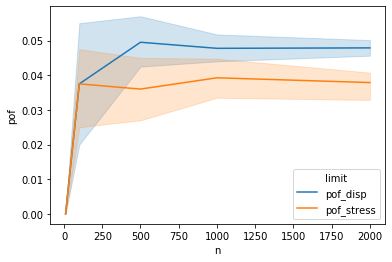

In [15]:
# -- EXAMPLE CODE; RUN AS-IS ----
import pandas as pd
import seaborn as sns

N_all = [10, 100, 500, 1000, 2000]
n_rep = 4

## Generate data
df_all = pd.DataFrame()
for n in N_all:
    for i in range(n_rep):
        df_new = (
            md_beam
            >> gr.ev_monte_carlo(df_det="nom", n=n, seed=101 + i)
            >> gr.tf_summarize(
                pof_disp=gr.mean(X.g_disp <= 0),
                pof_stress=gr.mean(X.g_stress <= 0),
            )
            >> gr.tf_mutate(n=n, repl=i)
        )
        df_all = pd.concat((df_all, df_new), axis=0)

## Visualize
sns.lineplot(
    data=df_all >> gr.tf_gather("limit", "pof", ["pof_disp", "pof_stress"]),
    x="n",
    y="pof",
    hue="limit"
)


## Rule of Thumb: Monte Carlo Sample Size

> When trying to estimate a probability `p` with Monte Carlo, choose a sample size of at least `n > 10 / p`.

Note that there's an obvious chicken-and-egg problem with this rule-of-thumb; if we knew `p` we wouldn't need to estimate it! In practice we may need to use our intuition and prior knowledge to choose an initial sample size, and *assess* the stability of our estimates. We can often follow up with more simulations if we deem it necessary.

We'll look at assessing Monte Carlo results in a future notebook; for now we'll briefly demonstrate one means to assess results: *confidence intervals*.

### Bonus Content: Confidence Intervals

We'll cover confidence intervals in a future notebook; for now, know that a confidence interval (CI) gives us a credible range for an estimate. We can construct CI bounds for our POF estimates using the following summary functions.


In [16]:
(
    md_beam
    >> gr.ev_monte_carlo(df_det="nom", n=10, seed=101)
    >> gr.tf_summarize(
        pof_lo=gr.binomial_ci(X.g_disp <= 0, side="lo"),
        pof_mu=gr.mean(X.g_disp <= 0),
        pof_up=gr.binomial_ci(X.g_disp <= 0, side="up"),
    )
)

,pof_lo,pof_mu,pof_up
0,0.0,0.0,0.277533


Note that the *mean* estimate for the POF is zero, but the *upper confidence level* is $\approx28\%$. This very wide confidence interval $(0, 0.28)$ signals that our estimate is *very* unstable. In this way, CI width can help us determine if our estimates are sufficiently accurate for an intended purpose.


# Next Steps
When you are done, please take [this survey](https://docs.google.com/forms/d/e/1FAIpQLScxvTwgfsp62ZboDwRl04WbJ4DtYppeU-4kd48uLGNHjIDFEg/viewform?usp=pp_url&entry.923399158=4088579) about the exercise.

This is the end of tutorials... for now!
